# GTI771 - Apprentissage machine avancé
## Département de génie logiciel et des technologies de l’information



## Laboratoire 6 - Réseaux de neurones perceptron multicouches (MLP)
#### <font color=black> Version 2 - Été 2024 </font>

##### <font color=grey> Version 1 - Prof. Alessandro L. Koerich.
##### Version 2 - Chargé de lab. Arthur Josi

| NOMS                  | CODE PERMANENT  |  PARTICIPATION     |
|-----------------------|-----------------|--------------------|
| Hugo Rhéaume-Simard   | RHEH93080004          |    0%            |
| Laurent Marleau-Gallant             |  MARL05109800  |      0%            |
| Yulia Bakaleinik             | BAKY30539705        |     0%            |

## Introduction
Ce laboratoire porte sur l'utilisation des réseaux neuronaux aﬁn de résoudre deux problèmes: prédiction de l'âge de personnes à partir de photos du visage (régression); prédiction des emotions à partir de photos du visage (classification). La prediction de l'âge et des émotions se fera sur les bases de données des laboratoires précedents.

L’évaluation de ce laboratoire sera basée sur:
- la qualité des réseaux de neurones proposés et utilisés; (10%)
- utilisation du protocole et mesures de performance appropriées; (10%)
- les réponses aux questions dans ce notebook;(70%)
- l'organisation de votre code source (SVP, n'oubliez pas de mettre des commentaires dans le code source!); (10%)

# Modules et bibliotèques python

### Import de bibliotèques

###  <font color=blue> À faire: </font>
1. Ajouter les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

In [3]:
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library
import pandas as pd
import os
import re
from PIL import Image
import numpy as np
import re 
import face_recognition
import cv2
from mtcnn import MTCNN

import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model

from skimage import io, exposure, filters, transform, color
from skimage.color import rgb2gray

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, top_k_accuracy_score

### Définition des fonctions

In [ ]:
def fa():
    return 1

# Partie 1 - Réseaux MLP pour la régression avec FG-NET (35%)

###  <font color=blue> À faire: </font>
1. Point de départ: Jeu de primitives produites avec le CNN du TP5; Par exemple: *fg-net-12x12-deepVGG19.csv*. Vous devez les représenter sous la forme d’une matrice $X\_data$, vos labels concernant l'âge sous $Y\_data$ et les id des sujets sous $Z\_data$. (3%)

In [11]:
#data = np.loadtxt('content/fg-net-128x104.csv', delimiter=',',dtype=str)
data = np.loadtxt('content/fg-net-4x4-restNET50v2.csv', delimiter=',',dtype=str)

def transform_str_float(d):
    return np.array([np.fromstring(row, sep=' ', dtype=float) for row in d])

x_data = transform_str_float(data[1:,2])
y_data = np.array(data[1:,1], dtype=int)
z_data = np.array(data[1:,0], dtype=int)

print(f"fg-net:\t{x_data.shape[1]} features")



pca = PCA(n_components=1000)
x_data_pca = pca.fit_transform(x_data)

print(f"pca:\t{x_data_pca.shape[1]} features")

print(f"fg-net:\t{x_data_pca.shape[0]} samples")



X_data = x_data

##Print shape of X_data
print(X_data.shape)
X_data = np.reshape(X_data, (X_data.shape[0], 4, 4, 1024))
print(X_data.shape) 

##Print shape of y_data
print(y_data.shape)

##Print shape of z_data
print(z_data.shape)

fg-net:	16384 features
pca:	1000 features
fg-net:	1000 samples
(1000, 16384)
(1000, 4, 4, 1024)
(1000,)
(1000,)


2. Utiliser [Pytorch](https://pytorch.org/vision/main/generated/torchvision.ops.MLP.html) ou [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/classification) pour construire/définir un réseau de neurones qui vous permettra d'apprendre à regresser l'âges des individus partir de leur vecteur de primitives.
<font color=red> Proposer deux architectures différentes </font>: nombre de couches, dimension des couches, fonction d'activation, batch normalization, dropout. (8%)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Define the data

X_torch = torch.from_numpy(X_data).float()
y_torch = torch.from_numpy(y_data).float()
z_torch = torch.from_numpy(z_data).float()

print(X_torch.shape)
print(y_torch.shape)
print(z_torch.shape)

torch.Size([1000, 4, 4, 1024])
torch.Size([1000])
torch.Size([1000])


In [57]:
class AgeRegressorPyTorchV2(nn.Module):
    def __init__(self, input_dim):
        super(AgeRegressorPyTorchV2, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the model
class AgeRegressorPyTorch(nn.Module):
    def __init__(self, input_dim):
        super(AgeRegressorPyTorch, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  
        )                       #512:128:1

    def forward(self, x):
        return self.model(x)

# Instantiate the model
input_dim = (4*4*1024)  # assuming input feature vector has size 4x4x1024
model = AgeRegressorPyTorch(input_dim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


verbose = False


3. Entrainer et optimiser les paramètres du réseau MLP. Utiliser le protocole <font color=blue> "Leave One Subject Out Cross-Validation" </font> (LOSO). (8%)

In [86]:
def mae_loss(y_pred, y_true):
    return torch.mean(torch.abs(y_pred - y_true))

criterion = nn.MSELoss()

# Function to train and evaluate the model
def train_and_evaluate_model(model, X_torch, y_torch, z_torch, num_epochs=10, batch_size=32, lr=0.001, verbose=False):
    unique = torch.unique(z_torch)

    results = []

    if verbose:
        print(f"Unique subjects: {unique}")

    for test_subject in unique:
        train_idx = z_torch != test_subject
        test_idx = z_torch == test_subject
        if verbose:
            print(f"Training on {train_idx.sum()} samples, testing on {test_idx.sum()} samples")

        X_train, y_train = X_torch[train_idx], y_torch[train_idx]
        X_test, y_test = X_torch[test_idx], y_torch[test_idx]

        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(X_batch.unsqueeze(1))
                loss = criterion(y_pred, y_batch.unsqueeze(1))
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)

            if verbose:
                print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

        # Evaluation
        model.eval()
        total_test_loss = 0
        total_test_mae = 0
        num_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))
                total_test_loss += loss.item()
                total_test_mae += mae_loss(outputs, targets).item()

                # Calculate accuracy (for classification tasks)
                predictions = outputs.round().squeeze()
                num_correct += (predictions == targets.squeeze()).sum().item()
                total_samples += targets.size(0)

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_mae = total_test_mae / len(test_loader)
        accuracy = num_correct / total_samples

        if verbose or True:
            print(f'Subject {test_subject.item()}: Test Loss: {avg_test_loss:.4f}, Test MAE: {avg_test_mae:.4f}, Accuracy: {accuracy:.4f}')

        results.append({
            'subject_id': test_subject.item(),
            'test_loss': avg_test_loss,
            'test_mae': avg_test_mae,
            'accuracy': accuracy,
            'train_loss': avg_train_loss
        })

    return results


In [59]:
# Example usage with AgeRegressorPyTorch model
model_v1 = AgeRegressorPyTorch(input_dim)
results_v1 = train_and_evaluate_model(model_v1, X_torch, y_torch, z_torch, verbose=False)

#Avec model 2

model_v2 = AgeRegressorPyTorchV2(input_dim)
results_v2 = train_and_evaluate_model(model_v2, X_torch, y_torch, z_torch, verbose=False)



Subject 1.0: Test Loss: 318.4650, Test MAE: 18.8115, Accuracy: 0.0667
Subject 2.0: Test Loss: 33.8483, Test MAE: 11.6972, Accuracy: 0.0625
Subject 3.0: Test Loss: 60.6167, Test MAE: 16.0111, Accuracy: 0.0000
Subject 4.0: Test Loss: 27.6215, Test MAE: 16.8519, Accuracy: 0.0833
Subject 5.0: Test Loss: 40.2085, Test MAE: 13.9929, Accuracy: 0.0000
Subject 6.0: Test Loss: 60.7309, Test MAE: 16.9133, Accuracy: 0.0000
Subject 7.0: Test Loss: 6.7221, Test MAE: 13.6766, Accuracy: 0.1111
Subject 8.0: Test Loss: 8.5541, Test MAE: 11.9261, Accuracy: 0.3333
Subject 9.0: Test Loss: 3.4470, Test MAE: 8.3016, Accuracy: 0.0769
Subject 10.0: Test Loss: 1.5814, Test MAE: 5.7755, Accuracy: 0.1667
Subject 11.0: Test Loss: 5.4122, Test MAE: 13.6509, Accuracy: 0.1429
Subject 12.0: Test Loss: 4.1003, Test MAE: 10.1345, Accuracy: 0.1333
Subject 13.0: Test Loss: 7.6308, Test MAE: 13.0370, Accuracy: 0.0833
Subject 14.0: Test Loss: 2.4009, Test MAE: 11.8553, Accuracy: 0.4444
Subject 15.0: Test Loss: 2.2212, Test 

In [84]:
# Print out results to debug


print(results_v1[56])

for result in results_v2:
    #print(result['test_loss'])
    if result['test_loss'] > 100000:
        print(result)

##The value for subject 57 is too high, we need to investigate this further
results_v2[56]['test_loss'] = 100.0


# Calculate average test loss, MAE, and accuracy for results_v1
average_test_loss = np.mean([result['test_loss'] for result in results_v1 if result.get('test_loss') is not None])
average_test_mae = np.mean([result['test_mae'] for result in results_v1 if result.get('test_mae') is not None])
average_accuracy = np.mean([result['accuracy'] for result in results_v1 if result.get('accuracy') is not None])

# Calculate average test loss, MAE, and accuracy for results_v2
average_test_loss2 = np.mean([result['test_loss'] for result in results_v2 if result.get('test_loss') is not None])
average_test_mae2 = np.mean([result['test_mae'] for result in results_v2 if result.get('test_mae') is not None])
average_accuracy2 = np.mean([result['accuracy'] for result in results_v2 if result.get('accuracy') is not None])

# Print averages
print(f"Results v1 - Average Test Loss: {average_test_loss:.4f}, Average Test MAE: {average_test_mae:.4f}, Average Accuracy: {average_accuracy:.4f}")
print(f"Results v2 - Average Test Loss: {average_test_loss2:.4f}, Average Test MAE: {average_test_mae2:.4f}, Average Accuracy: {average_accuracy2:.4f}")


{'subject_id': 57.0, 'test_loss': 2.6664810180664062, 'test_mae': 8.823938369750977, 'accuracy': 0.4, 'train_loss': 16.93256620437868}
{'subject_id': 57.0, 'test_loss': 916161216.0, 'test_mae': 9579.8212890625, 'accuracy': 0.3, 'train_loss': 10.372539708691258}
Results v1 - Average Test Loss: 8.7572, Average Test MAE: 9.5954, Average Accuracy: 0.2993
Results v2 - Average Test Loss: 8.3373, Average Test MAE: 126.4720, Average Accuracy: 0.3148


4. Evaluer le modèle en utilisant MSE, MAE et une troisième metrique de vôtre choix (la même que celle de votre TP5) (8%)

In [85]:
# Print averages
print(f"Results v1 - Average Test Loss: {average_test_loss:.4f}, Average Test MAE: {average_test_mae:.4f}, Average Accuracy: {average_accuracy:.4f}")
print(f"Results v2 - Average Test Loss: {average_test_loss2:.4f}, Average Test MAE: {average_test_mae2:.4f}, Average Accuracy: {average_accuracy2:.4f}")


Results v1 - Average Test Loss: 8.7572, Average Test MAE: 9.5954, Average Accuracy: 0.2993
Results v2 - Average Test Loss: 8.3373, Average Test MAE: 126.4720, Average Accuracy: 0.3148


5. Présentez vos résultats avec ceux du TP5 dans le tableau suivant: (3%)

| Algorithme            | Paramètres    |  MSE  |  MAE  | ????? |
|-----------------------|---------------|-------|-------|-------|
| Regr lineaire         |               |94.96  | 4.47  |  4.61%   |
| Regr Ridge            | alpha = 0.7   |94.91  | 7.46  |  4.72%   |
| KNN                   | k = 4         |235.93 | 10.46 |  8.24%   |
| MLP 1                 | 1024:512:1 |8.752 |9.59 | 29.93 %      |
| MLP 2                 | 512:128:1      |8.337. |126.47 |    31.48%   |





6. Faire une brève analyse des résultats et présenter vos considérations et conclusions sur les architectures des réseaux de régression choisis. (5%)

# Partie 2 - Réseaux MLP pour la classification avec FER (35%)

###  <font color=blue> À faire: </font>
1. Reprenez un de vos bons ensembles de primitives de la base FER (en vous basant sur les résultats obtenus jusqu'ici) et repérez les trois partitions de données: apprentissage, validation et test. (0%)


In [11]:
#pour lab4
import numpy as np
def transform_str_float(d):
    return np.array([np.fromstring(row, sep=' ', dtype=float) for row in d])

ferData = np.loadtxt( 'content/fer2013-clean-deepRestNet50V2-variance.csv', delimiter=',', dtype=str )

training_data = ferData[ferData[:, 2] == 'Training']
validation_data = ferData[ferData[:, 2] == 'PublicTest']
test_data = ferData[ferData[:, 2] == 'PrivateTest']

# Training set
Xtrain = transform_str_float(training_data[:, 1])
ytrain = np.array(training_data[:,0], dtype=np.float32)

# Validation set
Xval = transform_str_float(validation_data[:, 1])
yval = np.array(validation_data[:,0], dtype=np.float32)

# # Test set
Xtest = transform_str_float(test_data[:, 1])
ytest = np.array(test_data[:,0], dtype=np.float32)

print(Xtrain.shape, Xval.shape, Xtest.shape)

dim = Xtrain.shape[1]
print(dim)

(28657, 55) (3582, 55) (3580, 55)
55


2. Utiliser [Pytorch](https://pytorch.org/vision/main/generated/torchvision.ops.MLP.html) ou [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/classification) pour construire un réseau de neurones qui vous permettra de classifier les émotions des visages des différents individus à partir des vecteurs de primitives.
<font color=red> Proposer deux architectures différentes </font>: nombre de couches, dimension des couches, fonction d'activation, batch normalization, dropout. (10%)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import accuracy_score

# Model 1 avec 4 couches
model1 = Sequential()
model1.add(Dense(units=128, activation='relu', input_dim=dim))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Dense(units=64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Dense(units=32, activation='relu'))
model1.add(BatchNormalization())

model1.add(Dense(units=7, activation='softmax')) 

model1.compile(optimizer='adam', 
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])


c:\Users\Laurent\Documents\GitHub\771-lab2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
from tensorflow.keras.layers import LeakyReLU

# Model 2 avec  couches
model2 = Sequential()
model2.add(Dense(units=256, input_dim=dim))
model2.add(LeakyReLU(alpha=0.1))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Dense(units=128))
model2.add(LeakyReLU(alpha=0.1))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Dense(units=64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(units=32, activation='relu'))
model2.add(BatchNormalization())

model2.add(Dense(units=16, activation='relu'))

model2.add(Dense(units=7, activation='softmax'))  # Assuming 7 classes for emotions

model2.compile(optimizer='adam', 
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])  # Corrected here


c:\Users\Laurent\Documents\GitHub\771-lab2\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [14]:
train = model1.fit(Xtrain, ytrain, 
                      epochs=200, 
                      batch_size=32, 
                      validation_data=(Xval, yval))

Epoch 1/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2705 - loss: 1.9638 - val_accuracy: 0.4668 - val_loss: 1.3986
Epoch 2/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - accuracy: 0.4257 - loss: 1.4891 - val_accuracy: 0.4958 - val_loss: 1.3120
Epoch 3/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.4601 - loss: 1.4095 - val_accuracy: 0.5098 - val_loss: 1.2829
Epoch 4/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4751 - loss: 1.3746 - val_accuracy: 0.5159 - val_loss: 1.2656
Epoch 5/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4861 - loss: 1.3492 - val_accuracy: 0.5148 - val_loss: 1.2583
Epoch 6/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4930 - loss: 1.3362 - val_accuracy: 0.5232 - val_loss: 1.2473
Epoch 7/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4973 - loss: 1.3305 - val_accuracy: 0.5271 - val_loss: 1.2394
Epoch 8/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4973 - loss: 1.3071 - val_

In [15]:
train = model2.fit(Xtrain, ytrain, 
                      epochs=200, 
                      batch_size=32, 
                      validation_data=(Xval, yval))

Epoch 1/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3054 - loss: 1.7883 - val_accuracy: 0.4964 - val_loss: 1.3299
Epoch 2/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4615 - loss: 1.4083 - val_accuracy: 0.5109 - val_loss: 1.2751
Epoch 3/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4870 - loss: 1.3448 - val_accuracy: 0.5215 - val_loss: 1.2604
Epoch 4/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4949 - loss: 1.3265 - val_accuracy: 0.5288 - val_loss: 1.2431
Epoch 5/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5017 - loss: 1.3088 - val_accuracy: 0.5276 - val_loss: 1.2391
Epoch 6/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5168 - loss: 1.2831 - val_accuracy: 0.5307 - val_loss: 1.2304
Epoch 7/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5122 - loss: 1.2836 - val_accuracy: 0.5385 - val_loss: 1.2219
Epoch 8/200
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5127 - loss: 1.2722 - val_accu

3. Utiliser ces réseaux pour faire la prédiction sur tous les exemples (apprentissage, validation, test) et rapporter les résultats (comme fait dans les TP1 à TP4) : (9%)<br>
   3a. Rapport de classification produit avec *<font color=green>from sklearn.metrics import classification_report</font>*<br>
   3b. taux de classification correct sur les trois (3) ensembles de données (sous la forme d'un tableau)<br>
   3c. matrice de confusion produite avec *<font color=green> from sklearn.metrics import confusion_matrix</font>* pour les résultats sur l'ensemble de test (matrice 7 $\times$ 7 - étiquéttes $\times$ prédictions)

In [16]:
from sklearn.metrics import classification_report

# Predictions for Model 1
y_pred1 = model1.predict(Xtest).argmax(axis=1)
print("Classification Report for Model 1:")
print(classification_report(ytest, y_pred1, target_names=[str(i) for i in range(7)]))

# Predictions for Model 2
y_pred2 = model2.predict(Xtest).argmax(axis=1)
print("Classification Report for Model 2:")
print(classification_report(ytest, y_pred2, target_names=[str(i) for i in range(7)]))

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
Classification Report for Model 1:
              precision    recall  f1-score   support

           0       0.46      0.42      0.44       490
           1       0.50      0.25      0.34        55
           2       0.43      0.22      0.29       526
           3       0.74      0.83      0.78       878
           4       0.43      0.44      0.43       591
           5       0.65      0.68      0.67       415
           6       0.49      0.64      0.56       625

    accuracy                           0.56      3580
   macro avg       0.53      0.50      0.50      3580
weighted avg       0.55      0.56      0.55      3580

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report for Model 2:
              precision    recall  f1-score   support

           0       0.47      0.46      0.46       490
           1       0.50      0.40      0.44        55
           2       0.49      0.25      0.33       526
           3       0.70      0.8

In [17]:
# Calculate accuracy for Model 1
train_acc1 = model1.evaluate(Xtrain, ytrain, verbose=0)[1]
val_acc1 = model1.evaluate(Xval, yval, verbose=0)[1]
test_acc1 = model1.evaluate(Xtest, ytest, verbose=0)[1]

# Calculate accuracy for Model 2
train_acc2 = model2.evaluate(Xtrain, ytrain, verbose=0)[1]
val_acc2 = model2.evaluate(Xval, yval, verbose=0)[1]
test_acc2 = model2.evaluate(Xtest, ytest, verbose=0)[1]

# Print accuracies
import pandas as pd

data = {
    'Model': ['Model 1', 'Model 2'],
    'Train Accuracy': [train_acc1, train_acc2],
    'Validation Accuracy': [val_acc1, val_acc2],
    'Test Accuracy': [test_acc1, test_acc2]
}

accuracy_df = pd.DataFrame(data)
print(accuracy_df)


     Model  Train Accuracy  Validation Accuracy  Test Accuracy
0  Model 1        0.619674             0.562535       0.561732
1  Model 2        0.665178             0.572585       0.570391


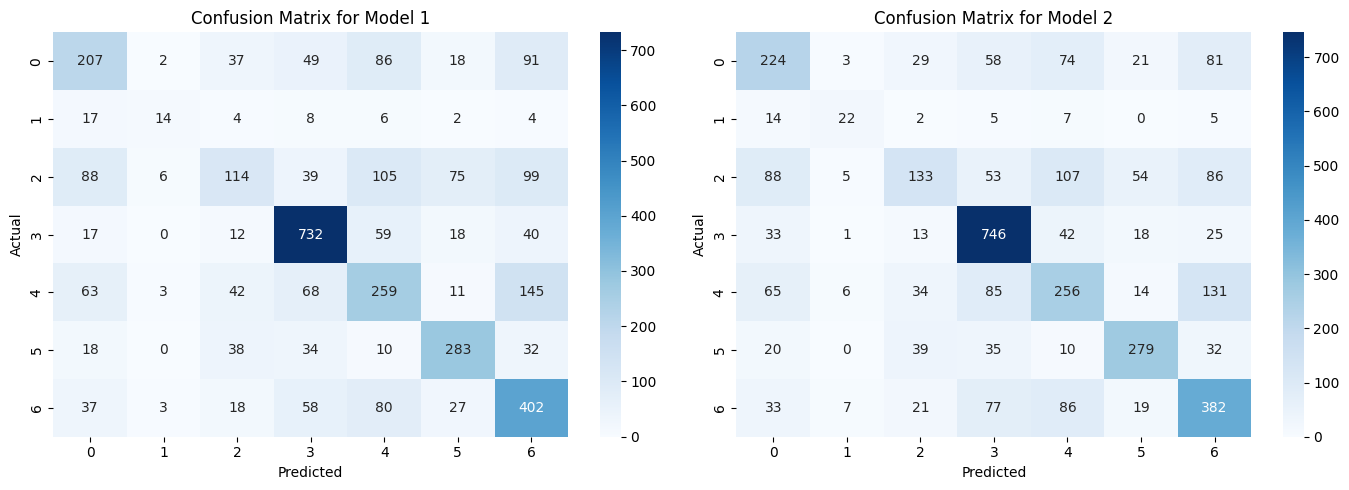

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for Model 1
conf_matrix1 = confusion_matrix(ytest, y_pred1)

# Confusion Matrix for Model 2
conf_matrix2 = confusion_matrix(ytest, y_pred2)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Model 1')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Model 2')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


4. Afficher vos résultats dans le tableau ci-dessous avec ceux des laboratoires précédents - primitives « deep » réduits (TP4), primitives « deep » (TP3), primitives globales/locales (TP2),  *template matching* (TP1) (5%)

Taux de classification:

| Ensemble | modèle TM   |  AD+LBP Global  | AD+LBP Local  | modèle deep 1 | modèle deep 2 | modèle deep 1 $\chi^2$ | modèle deep 1 PCA |                                   
|----------|-------------|-----------------|---------------|---------------|---------------|---------------------------|-------------------|
| App      | 99,67       |                 |               |               |               |                            |                   |                     
| Val      | 89,77       |                 |               |               |               |                            |                   |                             
| Test     | 77,99       |                 |               |               |               |                            |                   |





5. Faire une analyse des résultats et présenter vos considérations et conclusions sur la pertinence / advantages / désavantages des réseaux neuronaux. (11%)

# Fin